#### Imports & Downloads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score

from src.functions.vectorize_functions import vectorize_tfidf, vectorize_glove, vectorize_w2v

### Model Preparation

#### Functions

In [2]:
def print_target_distribution(df, colname):
    positive = np.count_nonzero(df[colname] == 1)
    negative = np.count_nonzero(df[colname] == 0)
    print("- Positive:", positive)
    print("- Negative:", negative)
    print("- Verhältnis:", negative / positive)

In [3]:
evaluation = pd.DataFrame(
    columns=["model", "tuning", "vec_variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc",
             "test_prec",
             "test_rec", "test_f1"])

In [4]:
def add_to_eval_df(model, model_name, tuning, vec_variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, tuning, vec_variant, train_acc, train_precision, train_recall,
                                             train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [5]:
def evaluate_model(model, x_test, y_test):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### Data Import

In [6]:
df_train_cleaned = pd.read_csv("..\\..\\..\\data\\twitter_hate-speech\\train_cleaned_rnn.csv")

In [7]:
print_target_distribution(df_train_cleaned, 'label')

- Positive: 1339
- Negative: 18950
- Verhältnis: 14.152352501867066


In [8]:
df_train_cleaned = df_train_cleaned[df_train_cleaned.tweet_cleaned.notna()]
df_train_cleaned.isna().sum()

id                   0
label                0
tweet                0
tweet_cleaned        0
user_handle          0
hashtags             0
emojis           16068
dtype: int64

#### Vectorize - Word2Vec

In [9]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = vectorize_w2v(df=df_train_cleaned,
                                                                 text_column="tweet_cleaned",
                                                                 label_column="label")

#### Vectorize - TF-IDF

In [10]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = vectorize_tfidf(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

#### Vectorize - Glove

In [11]:
X_train_gl, X_test_gl, y_train_gl, y_test_gl = vectorize_glove(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

### Training Functions

In [12]:
def cross_validate_model(model, x_data, y_data, cv=10, scoring='f1'):
    cv = cross_val_score(model, x_data, y_data, cv=cv, scoring=scoring, verbose=10)
    print(f" MEAN: {np.mean(cv)}")

    return cv

#### 1.1 Bagging

##### 1.1.1 RandomForest

In [13]:
def train_randomforest(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [14]:
def train_randomforest_tuned_randsearch(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
    model.fit(x_data, y_data)

    return model

In [15]:
def train_randomforest_tuned_optuna(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, n_estimators=450, max_depth=55, min_samples_split=4, min_samples_leaf=1)
    model.fit(x_data, y_data)

    return model

##### 1.1.2 BalancedRandomForest untuned

In [16]:
def train_balancedrandomforest(x_data, y_data):
    model = BalancedRandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [17]:
# def train_balancedrandomforest_tuned(x_data, y_data):
#     model = BalancedRandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
#     model.fit(x_data, y_data)
#
#     return model

#### 1.2 Boosting

##### 1.2.1 XGBClassifier

In [18]:
def train_xgboost(x_data, y_data):
    model = XGBClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [19]:
def train_xgboost_tuned_gridsearch(x_data, y_data):
    model = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
    model.fit(x_data, y_data)

    return model

In [20]:
def train_xgboost_tuned_randsearch(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, subsample=0.5, reg_alpha=1, n_estimators=150, min_child_weight=1,
                          max_depth=7, learning_rate=0.1, gamma=0.4)
    model.fit(x_data, y_data)

    return model

In [21]:
def train_xgboost_tuned_optuna(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, boost='gblinear', subsample=0.4736419905302216,
                          colsample_bytree=0.6711055768358083, alpha=8.528933855762793e-06)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 CatBoostClassifier

In [22]:
def train_catboost(x_data, y_data):
    model = CatBoostClassifier(iterations=100,
                               depth=5,
                               learning_rate=0.1,
                               loss_function='Logloss',
                               verbose=True)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 LGBMClassifier

In [23]:
def train_lightgbm(x_data, y_data):
    model = LGBMClassifier()
    model.fit(x_data, y_data)

    return model

#### 1.3 Stacking

##### 1.3.1 Stacking: RandomForest + LinearSVC

In [24]:
def train_stacking_rf_svm(x_data, y_data):
    base_models = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', LinearSVC(random_state=42))
    ]
    model = StackingClassifier(estimators=base_models, n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [25]:
def train_svc(x_data, y_data):
    model = LinearSVC()
    model.fit(x_data, y_data)

    return model

### Model Training

#### W2V

model accuracy for classification is = 93.71%
------------------------------------------------
Confusion Matrix:
      0   1
0  5668   6
1   377  36
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5674
           1       0.86      0.09      0.16       413

    accuracy                           0.94      6087
   macro avg       0.90      0.54      0.56      6087
weighted avg       0.93      0.94      0.91      6087



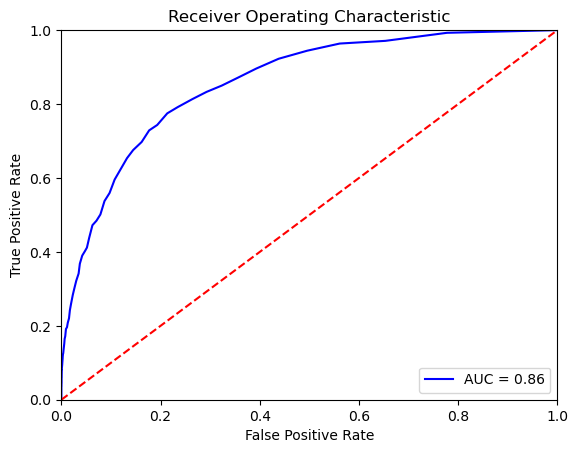

In [26]:
rf_untuned_w2v = train_randomforest(X_train_w2v, y_train_w2v)
evaluate_model(rf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_untuned_w2v, "RandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.40%
------------------------------------------------
Confusion Matrix:
      0   1
0  5671   3
1   399  14
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      5674
           1       0.82      0.03      0.07       413

    accuracy                           0.93      6087
   macro avg       0.88      0.52      0.52      6087
weighted avg       0.93      0.93      0.90      6087



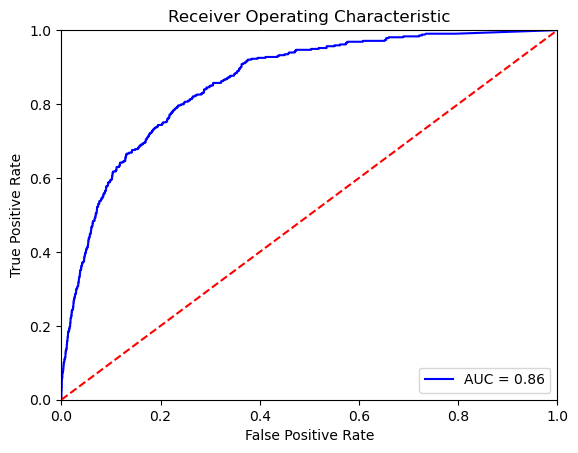

In [27]:
rf_rand_w2v = train_randomforest_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(rf_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_rand_w2v, "RandomForest", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.71%
------------------------------------------------
Confusion Matrix:
      0   1
0  5667   7
1   376  37
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5674
           1       0.84      0.09      0.16       413

    accuracy                           0.94      6087
   macro avg       0.89      0.54      0.56      6087
weighted avg       0.93      0.94      0.91      6087



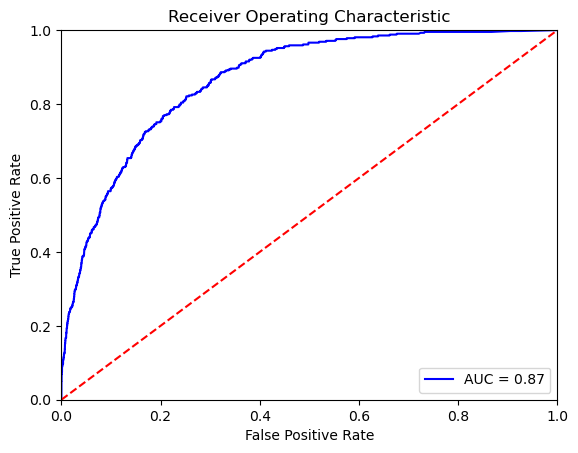

In [28]:
rf_optuna_w2v = train_randomforest_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(rf_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_optuna_w2v, "RandomForest", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 81.44%
------------------------------------------------
Confusion Matrix:
      0     1
0  4624  1050
1    80   333
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      5674
           1       0.24      0.81      0.37       413

    accuracy                           0.81      6087
   macro avg       0.61      0.81      0.63      6087
weighted avg       0.93      0.81      0.86      6087



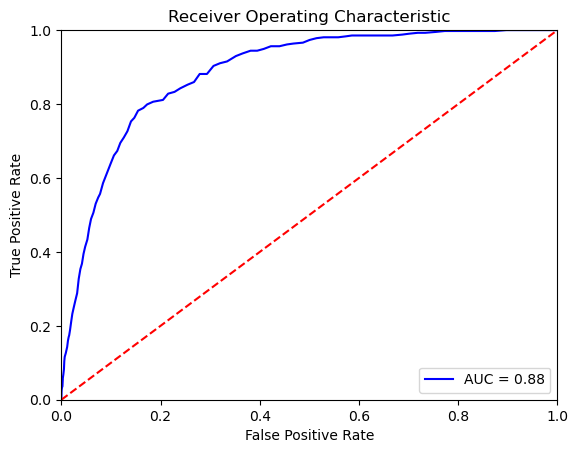

In [29]:
brf_untuned_w2v = train_balancedrandomforest(X_train_w2v, y_train_w2v)
evaluate_model(brf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(brf_untuned_w2v, "BalancedRandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

model accuracy for classification is = 93.76%
------------------------------------------------
Confusion Matrix:
      0   1
0  5634  40
1   340  73
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5674
           1       0.65      0.18      0.28       413

    accuracy                           0.94      6087
   macro avg       0.79      0.58      0.62      6087
weighted avg       0.92      0.94      0.92      6087



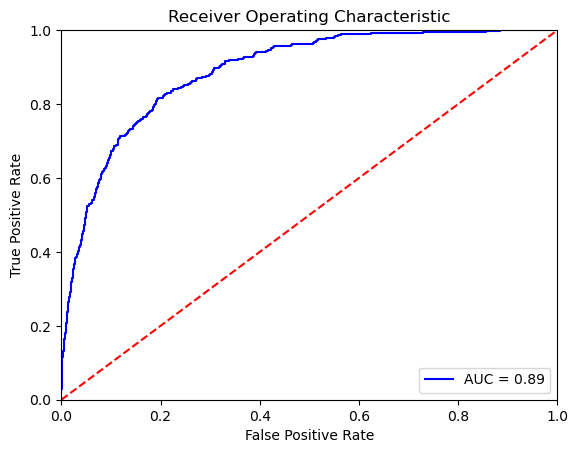

In [30]:
xgb_untuned_w2v = train_xgboost(X_train_w2v, y_train_w2v)
evaluate_model(xgb_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_untuned_w2v, "XGBoost", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.84%
------------------------------------------------
Confusion Matrix:
      0   1
0  5643  31
1   344  69
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5674
           1       0.69      0.17      0.27       413

    accuracy                           0.94      6087
   macro avg       0.82      0.58      0.62      6087
weighted avg       0.93      0.94      0.92      6087



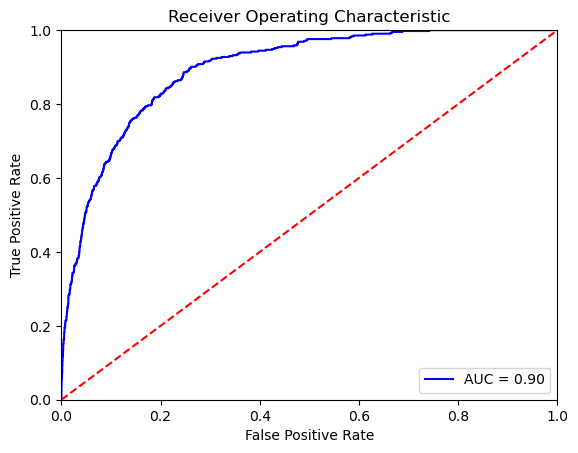

In [31]:
xgb_grid_w2v = train_xgboost_tuned_gridsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_grid_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_grid_w2v, "XGBoost", "gridsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.72%
------------------------------------------------
Confusion Matrix:
      0   1
0  5633  41
1   341  72
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5674
           1       0.64      0.17      0.27       413

    accuracy                           0.94      6087
   macro avg       0.79      0.58      0.62      6087
weighted avg       0.92      0.94      0.92      6087



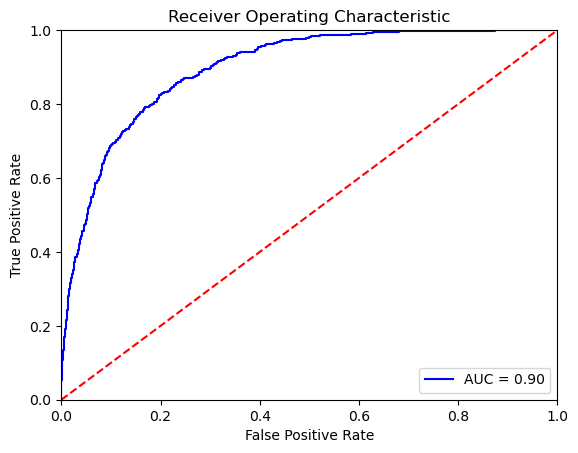

In [32]:
xgb_rand_w2v = train_xgboost_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_rand_w2v, "XGBoost", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:59:38] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 93.64%
------------------------------------------------
Confusion Matrix:
      0   1
0  5604  70
1   317  96
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.58      0.23      0.33       413

    accuracy                           0.94      6087
   macro avg       0.76      0.61      0.65      6087
weighted avg       0.92      0.94      0.92      6087



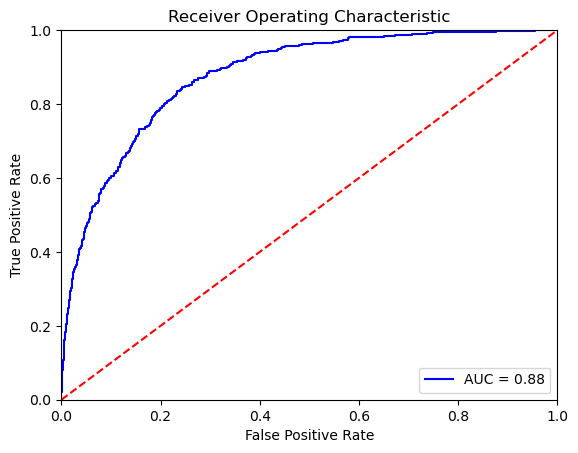

In [33]:
xgb_optuna_w2v = train_xgboost_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(xgb_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_optuna_w2v, "XGBoost", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

0:	learn: 0.5760418	total: 224ms	remaining: 22.2s
1:	learn: 0.4778234	total: 288ms	remaining: 14.1s
2:	learn: 0.4076184	total: 383ms	remaining: 12.4s
3:	learn: 0.3570892	total: 462ms	remaining: 11.1s
4:	learn: 0.3196947	total: 559ms	remaining: 10.6s
5:	learn: 0.2885357	total: 603ms	remaining: 9.45s
6:	learn: 0.2670075	total: 667ms	remaining: 8.87s
7:	learn: 0.2503617	total: 752ms	remaining: 8.65s
8:	learn: 0.2363285	total: 838ms	remaining: 8.47s
9:	learn: 0.2275629	total: 926ms	remaining: 8.34s
10:	learn: 0.2187006	total: 966ms	remaining: 7.81s
11:	learn: 0.2107472	total: 1.02s	remaining: 7.47s
12:	learn: 0.2052358	total: 1.06s	remaining: 7.12s
13:	learn: 0.2000686	total: 1.09s	remaining: 6.72s
14:	learn: 0.1955071	total: 1.13s	remaining: 6.39s
15:	learn: 0.1922287	total: 1.16s	remaining: 6.09s
16:	learn: 0.1901014	total: 1.2s	remaining: 5.88s
17:	learn: 0.1873042	total: 1.26s	remaining: 5.74s
18:	learn: 0.1850135	total: 1.32s	remaining: 5.65s
19:	learn: 0.1820985	total: 1.41s	remainin

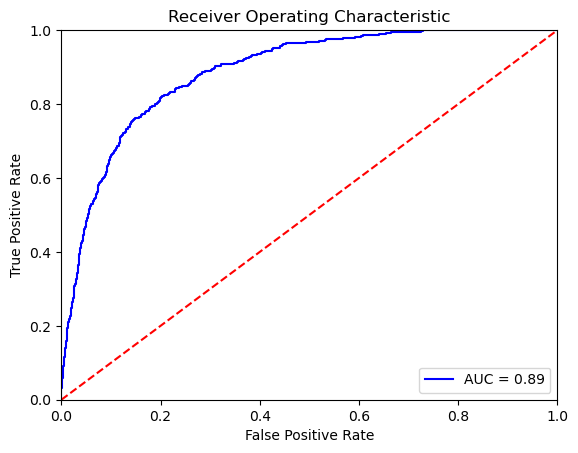

In [34]:
cat_untuned_w2v = train_catboost(X_train_w2v, y_train_w2v)
evaluate_model(cat_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(cat_untuned_w2v, "CatBoostClassifier", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

[LightGBM] [Info] Number of positive: 926, number of negative: 13275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 14201, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065207 -> initscore=-2.662764
[LightGBM] [Info] Start training from score -2.662764
model accuracy for classification is = 93.64%
------------------------------------------------
Confusion Matrix:
      0   1
0  5632  42
1   345  68
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5674
           1       0.62      0.16      0.26       413

    accuracy                           0.94      6087
   macro avg       0.78      0.58      0.61      6087
weighted avg 

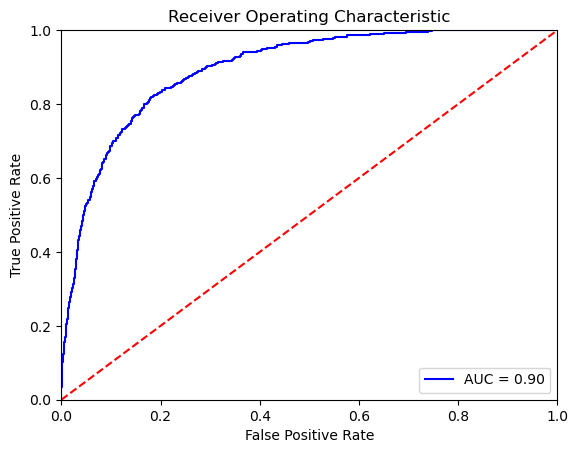

In [35]:
light_untuned_w2v = train_lightgbm(X_train_w2v, y_train_w2v)
evaluate_model(light_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(light_untuned_w2v, "LightGBM", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.56%
------------------------------------------------
Confusion Matrix:
      0   1
0  5610  64
1   328  85
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5674
           1       0.57      0.21      0.30       413

    accuracy                           0.94      6087
   macro avg       0.76      0.60      0.63      6087
weighted avg       0.92      0.94      0.92      6087



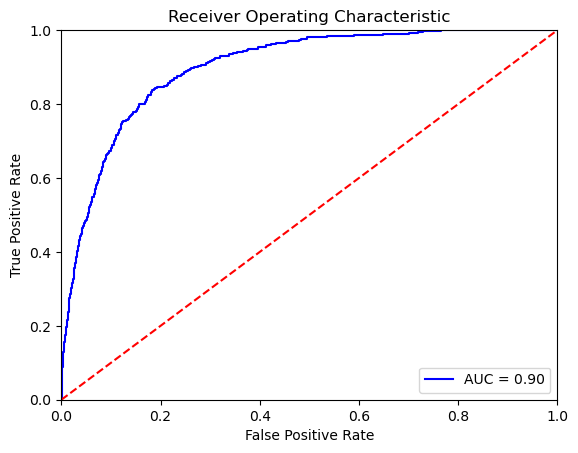

In [36]:
stack_untuned_w2v = train_stacking_rf_svm(X_train_w2v, y_train_w2v)
evaluate_model(stack_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(stack_untuned_w2v, "StackingClassifier-RF-SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

In [37]:
svc_untuned_w2v = train_svc(X_train_w2v, y_train_w2v)
add_to_eval_df(svc_untuned_w2v, "SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### TF-IDF

model accuracy for classification is = 95.22%
------------------------------------------------
Confusion Matrix:
      0    1
0  5656   18
1   273  140
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5674
           1       0.89      0.34      0.49       413

    accuracy                           0.95      6087
   macro avg       0.92      0.67      0.73      6087
weighted avg       0.95      0.95      0.94      6087



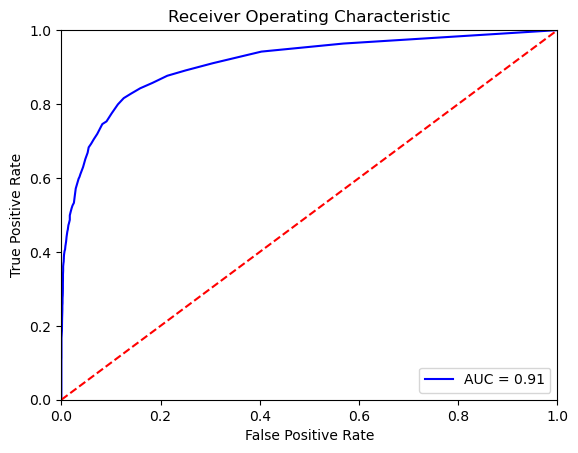

In [38]:
rf_untuned_tf = train_randomforest(X_train_tf, y_train_tf)
evaluate_model(rf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_untuned_tf, "RandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 94.15%
------------------------------------------------
Confusion Matrix:
      0   1
0  5636  38
1   318  95
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.71      0.23      0.35       413

    accuracy                           0.94      6087
   macro avg       0.83      0.61      0.66      6087
weighted avg       0.93      0.94      0.93      6087



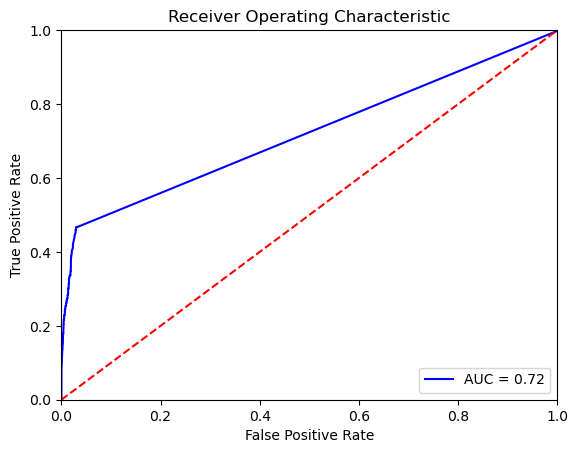

In [39]:
rf_rand_tf = train_randomforest_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(rf_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_rand_tf, "RandomForest", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 93.59%
------------------------------------------------
Confusion Matrix:
      0   1
0  5674   0
1   390  23
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5674
           1       1.00      0.06      0.11       413

    accuracy                           0.94      6087
   macro avg       0.97      0.53      0.54      6087
weighted avg       0.94      0.94      0.91      6087



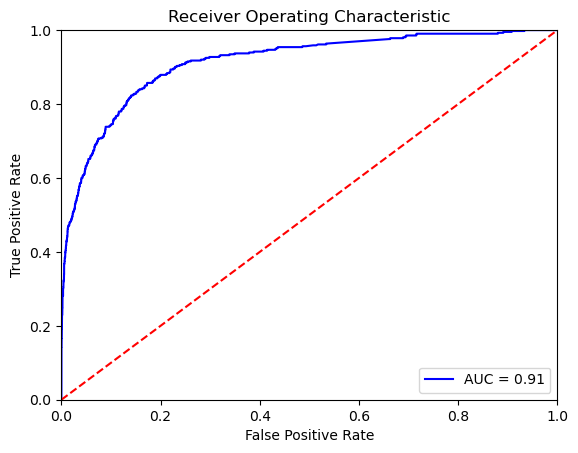

In [40]:
rf_optuna_tf = train_randomforest_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(rf_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_optuna_tf, "RandomForest", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 81.78%
------------------------------------------------
Confusion Matrix:
      0     1
0  4644  1030
1    79   334
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      5674
           1       0.24      0.81      0.38       413

    accuracy                           0.82      6087
   macro avg       0.61      0.81      0.63      6087
weighted avg       0.93      0.82      0.86      6087



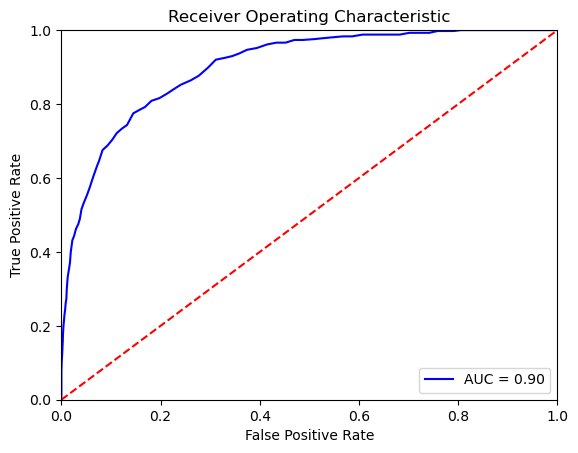

In [41]:
brf_untuned_tf = train_balancedrandomforest(X_train_tf, y_train_tf)
evaluate_model(brf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(brf_untuned_tf, "BalancedRandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 94.73%
------------------------------------------------
Confusion Matrix:
      0    1
0  5641   33
1   288  125
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.79      0.30      0.44       413

    accuracy                           0.95      6087
   macro avg       0.87      0.65      0.71      6087
weighted avg       0.94      0.95      0.94      6087



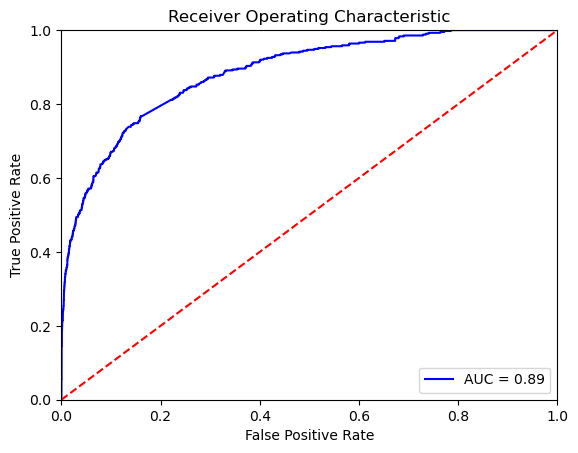

In [42]:
xgb_untuned_tf = train_xgboost(X_train_tf, y_train_tf)
evaluate_model(xgb_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_untuned_tf, "XGBoost", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 94.37%
------------------------------------------------
Confusion Matrix:
      0    1
0  5620   54
1   289  124
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.70      0.30      0.42       413

    accuracy                           0.94      6087
   macro avg       0.82      0.65      0.70      6087
weighted avg       0.93      0.94      0.93      6087



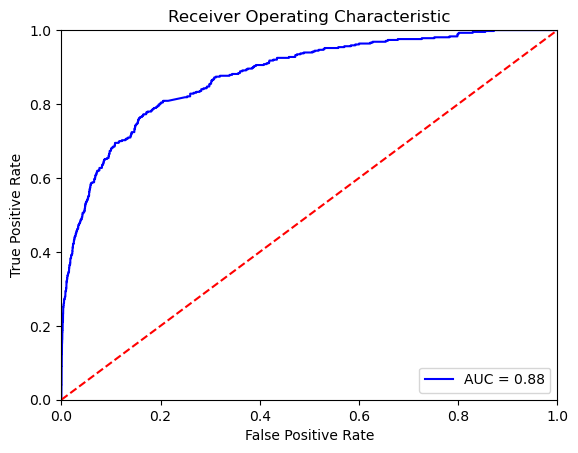

In [43]:
xgb_grid_tf = train_xgboost_tuned_gridsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_grid_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_grid_tf, "XGBoost", "gridsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 94.23%
------------------------------------------------
Confusion Matrix:
      0    1
0  5636   38
1   313  100
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.72      0.24      0.36       413

    accuracy                           0.94      6087
   macro avg       0.84      0.62      0.67      6087
weighted avg       0.93      0.94      0.93      6087



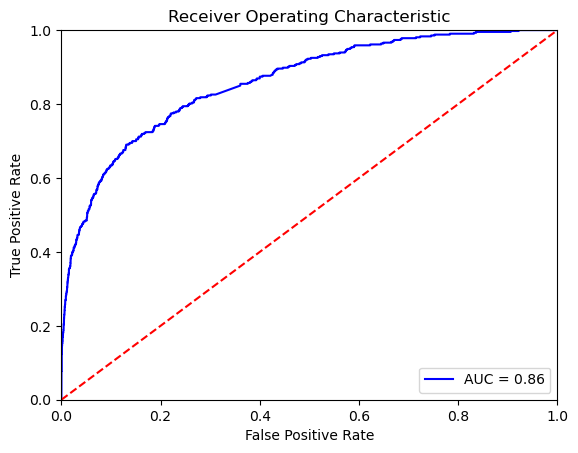

In [44]:
xgb_rand_tf = train_xgboost_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_rand_tf, "XGBoost", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:02:59] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 94.00%
------------------------------------------------
Confusion Matrix:
      0    1
0  5610   64
1   301  112
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.64      0.27      0.38       413

    accuracy                           0.94      6087
   macro avg       0.79      0.63      0.67      6087
weighted avg       0.93      0.94      0.93      6087



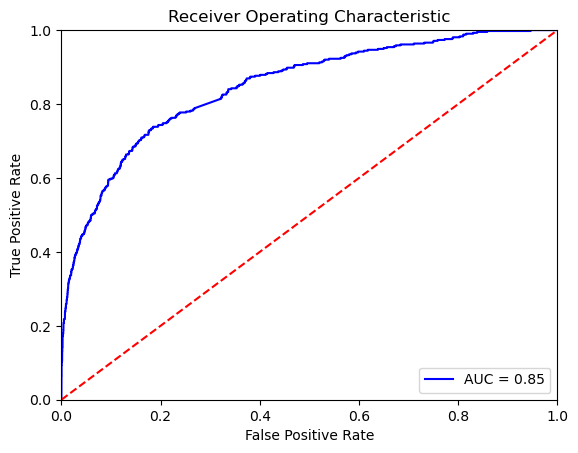

In [45]:
xgb_optuna_tf = train_xgboost_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(xgb_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_optuna_tf, "XGBoost", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

0:	learn: 0.5858038	total: 103ms	remaining: 10.2s
1:	learn: 0.5044487	total: 199ms	remaining: 9.75s
2:	learn: 0.4421598	total: 290ms	remaining: 9.37s
3:	learn: 0.3925543	total: 391ms	remaining: 9.38s
4:	learn: 0.3563120	total: 496ms	remaining: 9.43s
5:	learn: 0.3264342	total: 612ms	remaining: 9.59s
6:	learn: 0.3015693	total: 706ms	remaining: 9.37s
7:	learn: 0.2826535	total: 798ms	remaining: 9.18s
8:	learn: 0.2688912	total: 896ms	remaining: 9.06s
9:	learn: 0.2564681	total: 996ms	remaining: 8.96s
10:	learn: 0.2469143	total: 1.09s	remaining: 8.79s
11:	learn: 0.2400296	total: 1.19s	remaining: 8.71s
12:	learn: 0.2344608	total: 1.29s	remaining: 8.65s
13:	learn: 0.2287402	total: 1.39s	remaining: 8.55s
14:	learn: 0.2246132	total: 1.5s	remaining: 8.47s
15:	learn: 0.2205687	total: 1.59s	remaining: 8.34s
16:	learn: 0.2177155	total: 1.68s	remaining: 8.21s
17:	learn: 0.2149154	total: 1.78s	remaining: 8.11s
18:	learn: 0.2124877	total: 1.87s	remaining: 7.97s
19:	learn: 0.2106084	total: 1.96s	remainin

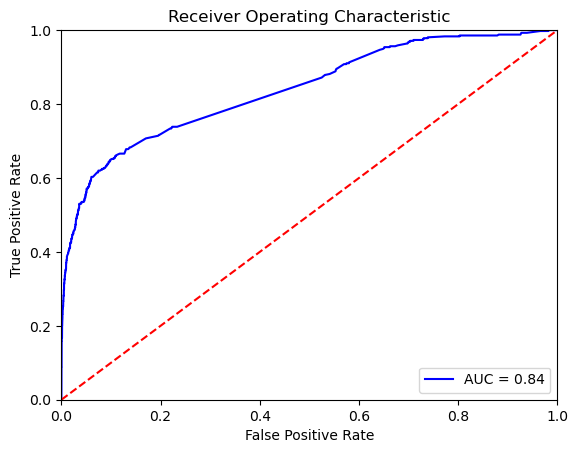

In [46]:
cat_untuned_tf = train_catboost(X_train_tf, y_train_tf)
evaluate_model(cat_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(cat_untuned_tf, "CatBoostClassifier", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

[LightGBM] [Info] Number of positive: 926, number of negative: 13275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35361
[LightGBM] [Info] Number of data points in the train set: 14201, number of used features: 1085
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065207 -> initscore=-2.662764
[LightGBM] [Info] Start training from score -2.662764
model accuracy for classification is = 94.25%
------------------------------------------------
Confusion Matrix:
      0    1
0  5616   58
1   292  121
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.68      0.29      0.41       413

    accuracy                           0.94      6087
   macro avg       0.81      0.64      0.69      6087
weighted 

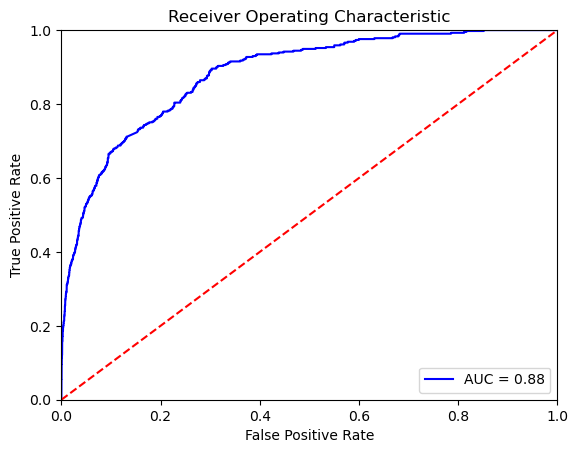

In [47]:
light_untuned_tf = train_lightgbm(X_train_tf, y_train_tf)
evaluate_model(light_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(light_untuned_tf, "LightGBM", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 95.47%
------------------------------------------------
Confusion Matrix:
      0    1
0  5600   74
1   202  211
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5674
           1       0.74      0.51      0.60       413

    accuracy                           0.95      6087
   macro avg       0.85      0.75      0.79      6087
weighted avg       0.95      0.95      0.95      6087



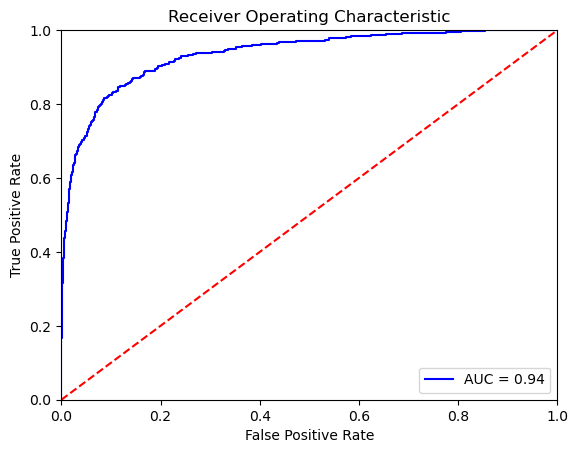

In [48]:
stack_untuned_tf = train_stacking_rf_svm(X_train_tf, y_train_tf)
evaluate_model(stack_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(stack_untuned_tf, "StackingClassifier-RF-SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf,
               y_test_tf)

In [49]:
svc_untuned_tf = train_svc(X_train_tf, y_train_tf)
add_to_eval_df(svc_untuned_tf, "SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

#### Glove100d

model accuracy for classification is = 93.72%
------------------------------------------------
Confusion Matrix:
      0   1
0  5663  11
1   371  42
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5674
           1       0.79      0.10      0.18       413

    accuracy                           0.94      6087
   macro avg       0.87      0.55      0.57      6087
weighted avg       0.93      0.94      0.91      6087



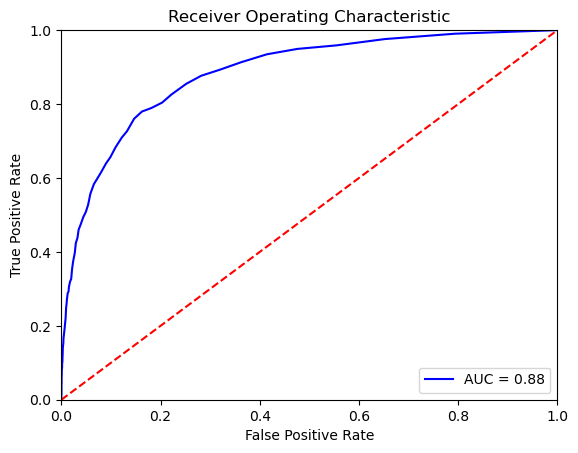

In [50]:
rf_untuned_gl = train_randomforest(X_train_gl, y_train_gl)
evaluate_model(rf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_untuned_gl, "RandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 93.43%
------------------------------------------------
Confusion Matrix:
      0   1
0  5662  12
1   388  25
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5674
           1       0.68      0.06      0.11       413

    accuracy                           0.93      6087
   macro avg       0.81      0.53      0.54      6087
weighted avg       0.92      0.93      0.91      6087



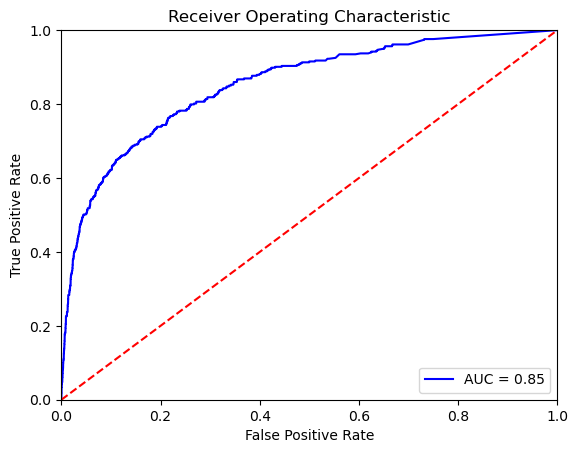

In [51]:
rf_rand_gl = train_randomforest_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(rf_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_rand_gl, "RandomForest", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 93.72%
------------------------------------------------
Confusion Matrix:
      0   1
0  5666   8
1   374  39
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5674
           1       0.83      0.09      0.17       413

    accuracy                           0.94      6087
   macro avg       0.88      0.55      0.57      6087
weighted avg       0.93      0.94      0.91      6087



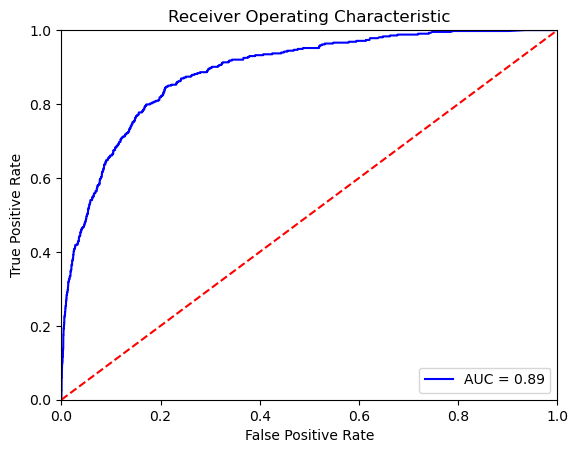

In [52]:
rf_optuna_gl = train_randomforest_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(rf_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_optuna_gl, "RandomForest", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 83.56%
------------------------------------------------
Confusion Matrix:
      0    1
0  4733  941
1    60  353
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      5674
           1       0.27      0.85      0.41       413

    accuracy                           0.84      6087
   macro avg       0.63      0.84      0.66      6087
weighted avg       0.94      0.84      0.87      6087



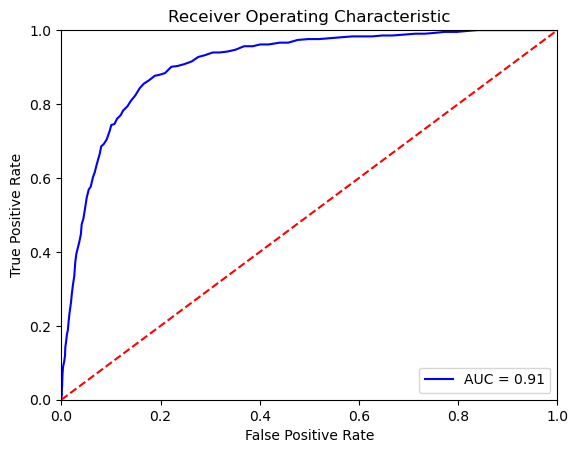

In [53]:
brf_untuned_gl = train_balancedrandomforest(X_train_gl, y_train_gl)
evaluate_model(brf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(brf_untuned_gl, "BalancedRandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.17%
------------------------------------------------
Confusion Matrix:
      0    1
0  5599   75
1   280  133
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.64      0.32      0.43       413

    accuracy                           0.94      6087
   macro avg       0.80      0.65      0.70      6087
weighted avg       0.93      0.94      0.93      6087



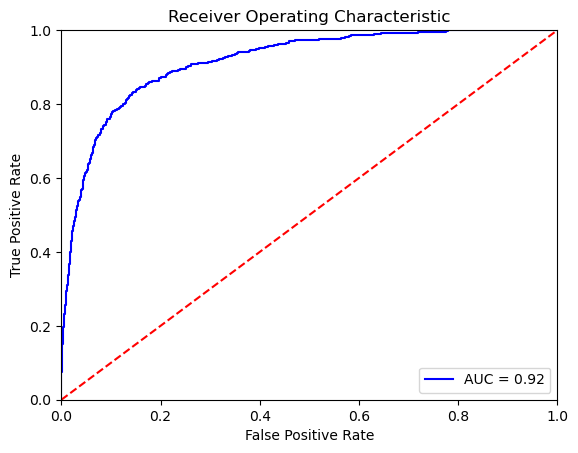

In [54]:
xgb_untuned_gl = train_xgboost(X_train_gl, y_train_gl)
evaluate_model(xgb_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_untuned_gl, "XGBoost", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.32%
------------------------------------------------
Confusion Matrix:
      0    1
0  5618   56
1   290  123
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.69      0.30      0.42       413

    accuracy                           0.94      6087
   macro avg       0.82      0.64      0.69      6087
weighted avg       0.93      0.94      0.93      6087



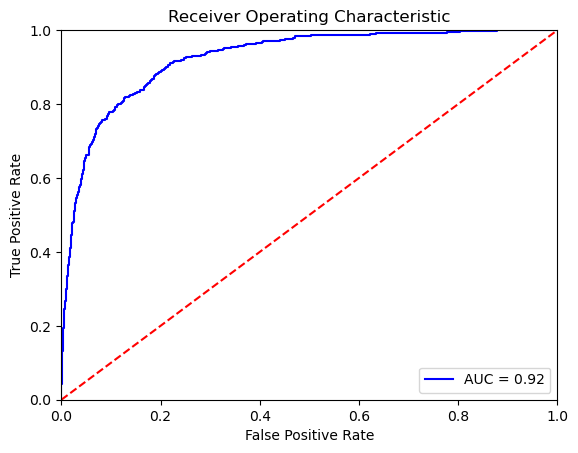

In [55]:
xgb_grid_gl = train_xgboost_tuned_gridsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_grid_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_grid_gl, "XGBoost", "gridsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.28%
------------------------------------------------
Confusion Matrix:
      0    1
0  5610   64
1   284  129
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.67      0.31      0.43       413

    accuracy                           0.94      6087
   macro avg       0.81      0.65      0.70      6087
weighted avg       0.93      0.94      0.93      6087



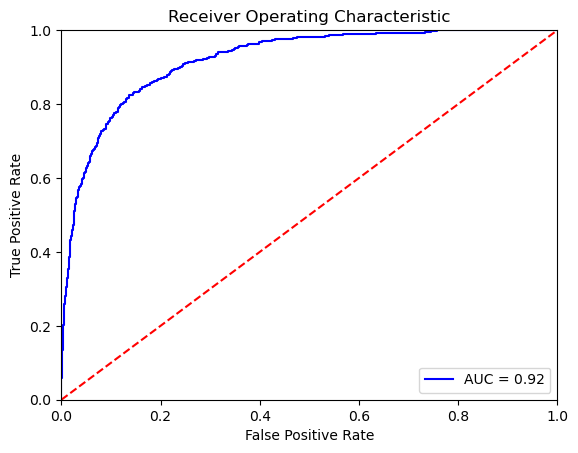

In [56]:
xgb_rand_gl = train_xgboost_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_rand_gl, "XGBoost", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:07:22] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 94.02%
------------------------------------------------
Confusion Matrix:
      0    1
0  5587   87
1   277  136
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5674
           1       0.61      0.33      0.43       413

    accuracy                           0.94      6087
   macro avg       0.78      0.66      0.70      6087
weighted avg       0.93      0.94      0.93      6087



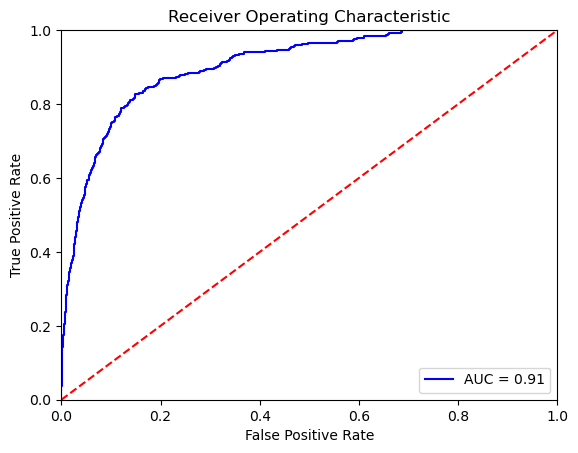

In [57]:
xgb_optuna_gl = train_xgboost_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(xgb_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_optuna_gl, "XGBoost", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

0:	learn: 0.5730039	total: 24ms	remaining: 2.37s
1:	learn: 0.4868080	total: 44.7ms	remaining: 2.19s
2:	learn: 0.4125995	total: 65ms	remaining: 2.1s
3:	learn: 0.3622642	total: 84ms	remaining: 2.02s
4:	learn: 0.3207596	total: 103ms	remaining: 1.96s
5:	learn: 0.2891286	total: 123ms	remaining: 1.92s
6:	learn: 0.2623937	total: 142ms	remaining: 1.88s
7:	learn: 0.2485309	total: 160ms	remaining: 1.84s
8:	learn: 0.2306793	total: 180ms	remaining: 1.82s
9:	learn: 0.2178639	total: 199ms	remaining: 1.79s
10:	learn: 0.2106629	total: 220ms	remaining: 1.78s
11:	learn: 0.2038994	total: 241ms	remaining: 1.77s
12:	learn: 0.1974510	total: 260ms	remaining: 1.74s
13:	learn: 0.1928725	total: 281ms	remaining: 1.73s
14:	learn: 0.1886703	total: 300ms	remaining: 1.7s
15:	learn: 0.1847319	total: 319ms	remaining: 1.67s
16:	learn: 0.1813072	total: 339ms	remaining: 1.65s
17:	learn: 0.1781316	total: 358ms	remaining: 1.63s
18:	learn: 0.1762196	total: 376ms	remaining: 1.6s
19:	learn: 0.1739320	total: 396ms	remaining: 1

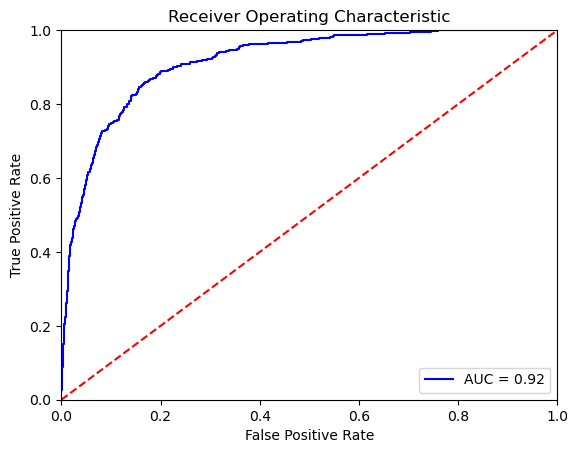

In [58]:
cat_untuned_gl = train_catboost(X_train_gl, y_train_gl)
evaluate_model(cat_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(cat_untuned_gl, "CatBoostClassifier", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

[LightGBM] [Info] Number of positive: 926, number of negative: 13275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 14201, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065207 -> initscore=-2.662764
[LightGBM] [Info] Start training from score -2.662764
model accuracy for classification is = 94.23%
------------------------------------------------
Confusion Matrix:
      0    1
0  5607   67
1   284  129
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.66      0.31      0.42       413

    accuracy                           0.94      6087
   macro avg       0.80      0.65      0.70      6087
weighted a

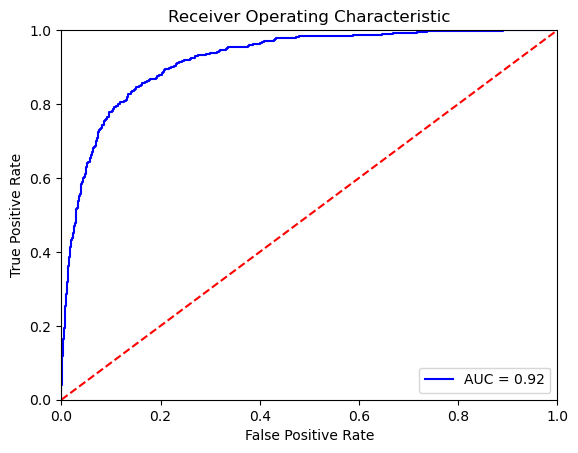

In [59]:
light_untuned_gl = train_lightgbm(X_train_gl, y_train_gl)
evaluate_model(light_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(light_untuned_gl, "LightGBM", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.20%
------------------------------------------------
Confusion Matrix:
      0    1
0  5601   73
1   280  133
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.65      0.32      0.43       413

    accuracy                           0.94      6087
   macro avg       0.80      0.65      0.70      6087
weighted avg       0.93      0.94      0.93      6087



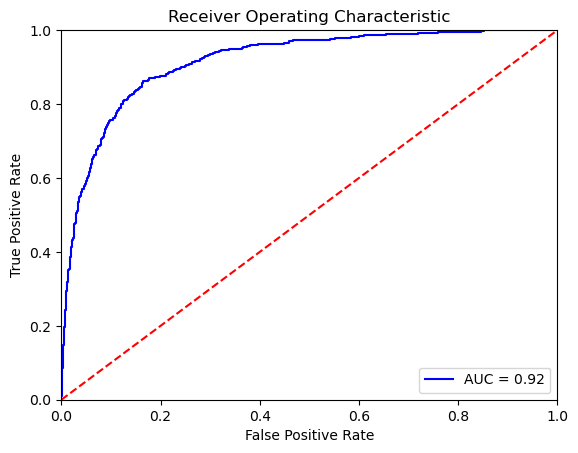

In [60]:
stack_untuned_gl = train_stacking_rf_svm(X_train_gl, y_train_gl)
evaluate_model(stack_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(stack_untuned_gl, "StackingClassifier-RF-SVC", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl,
               y_test_gl)

In [61]:
svc_untuned_gl = train_svc(X_train_gl, y_train_gl)
add_to_eval_df(svc_untuned_gl, "SVC", "untuned", "glove200d", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

### Model Evaluation

In [62]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,tuning,vec_variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
22,StackingClassifier-RF-SVC,untuned,tf,0.999789,0.996771,1.000000,0.998383,0.954657,0.740351,0.510896,0.604585
23,SVC,untuned,tf,0.996338,0.996591,0.947084,0.971207,0.955150,0.821101,0.433414,0.567353
12,RandomForest,untuned,tf,0.999930,1.000000,0.998920,0.999460,0.952193,0.886076,0.338983,0.490368
16,XGBoost,untuned,tf,0.965425,0.973856,0.482721,0.645487,0.947265,0.791139,0.302663,0.437828
34,StackingClassifier-RF-SVC,untuned,glove,0.972608,0.903759,0.649028,0.755500,0.942008,0.645631,0.322034,0.429725
28,XGBoost,untuned,glove,1.000000,1.000000,1.000000,1.000000,0.941679,0.639423,0.322034,0.428341
31,XGBoost,optuna,glove,0.999930,1.000000,0.998920,0.999460,0.940200,0.609865,0.329298,0.427673
30,XGBoost,randsearch,glove,0.999155,1.000000,0.987041,0.993478,0.942829,0.668394,0.312349,0.425743
33,LightGBM,untuned,glove,0.998592,1.000000,0.978402,0.989083,0.942336,0.658163,0.312349,0.423645
17,XGBoost,gridsearch,tf,0.971833,0.971326,0.585313,0.730458,0.943650,0.696629,0.300242,0.419628
